In [1]:
# 11_player_comparison_dashboard.ipynb
# 🆚 Player Comparison Dashboard

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("viridis")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())



Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 📊 What You'll Build

> **Beginner tip:** Treat each chart like a paragraph in a story. Pause after every visualization to say who leads that category and why it matters for their role.

Create a side-by-side view of your favorite players to evaluate roles and efficiency. You'll:
- confirm which seasons have player rate and shooting data
- choose a season plus the players you want to compare
- compute per-40, per-100, and shooting mix metrics
- visualize shot profiles, usage/efficiency blends, and radar views


In [2]:
# 📅 Discover available seasons
rate_seasons = sorted(p.stem for p in (DATA_DIR / 'player_season_stats').glob('*.csv'))
shooting_seasons = sorted(p.stem for p in (DATA_DIR / 'player_season_shooting_stats').glob('*.csv'))
print(f"Rate seasons available ({len(rate_seasons)}): {', '.join(rate_seasons[:10])}")
print(f"Shooting seasons available ({len(shooting_seasons)}): {', '.join(shooting_seasons[:10])}")



Rate seasons available (21): 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
Shooting seasons available (12): 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023


## 🛠️ Set analysis parameters
Begin with two well-known players. Once you trust the workflow, swap in prospects to evaluate them more objectively.

Update the players, thresholds, and metrics, then re-run the cell before proceeding.


In [5]:
# 🔁 Parameters
TARGET_SEASON = 2025  # choose any season listed above
PRIMARY_PLAYERS = ['Danny Wolf', 'Vladislav Goldin']
SECONDARY_PLAYERS = ['Tre Donaldson', 'Nimari Burnett', 'Rubin Jones', 'Roddy Gayle Jr.', 'Will Tschetter', 'L.J. Cason']  # add more names to broaden the comparison
MIN_MINUTES = 300
MIN_GAMES = 15
MIN_TRACKED_SHOTS = 100  # ensures reliable shot mix
PER40_METRICS = ['points_per40', 'rebounds_per40', 'assists_per40', 'turnovers_per40']
EFFICIENCY_METRICS = ['trueShootingPct', 'effectiveFieldGoalPct', 'offensiveRating', 'netRating']
RADAR_METRICS = ['usage', 'points_per40', 'assists_per40', 'rebounds_per40', 'trueShootingPct']
SHOT_TYPES = ['dunks', 'layups', 'tipIns', 'twoPointJumpers', 'threePointJumpers']
SHOT_LABELS = {
    'dunks': 'Dunks',
    'layups': 'Layups',
    'tipIns': 'Tip-ins',
    'twoPointJumpers': '2P Jumpers',
    'threePointJumpers': '3P Jumpers'
}
SCATTER_X = 'usage'
SCATTER_Y = 'effectiveFieldGoalPct'
HIGHLIGHT_PLAYERS = PRIMARY_PLAYERS  # players to annotate on plots

COMPARE_PLAYERS = list(dict.fromkeys(PRIMARY_PLAYERS + SECONDARY_PLAYERS))
print(f"Comparing {len(COMPARE_PLAYERS)} players: {', '.join(COMPARE_PLAYERS)}")



Comparing 8 players: Danny Wolf, Vladislav Goldin, Tre Donaldson, Nimari Burnett, Rubin Jones, Roddy Gayle Jr., Will Tschetter, L.J. Cason


## 📥 Load player season and shooting data
We load both rate stats and shot profiles so every chart stays in sync. Check the preview to make sure both players appear.

Pull season-level rate stats and merge available shooting splits for richer context.


In [6]:
# 🗂️ Read datasets
rate_path = DATA_DIR / 'player_season_stats' / f'{TARGET_SEASON}.csv'
if not rate_path.exists():
    raise FileNotFoundError(f"Player rate stats for {TARGET_SEASON} not found. Available: {rate_seasons}")

player_rates = pd.read_csv(rate_path)
print(f"Loaded rate stats: {player_rates.shape}")

shooting_path = DATA_DIR / 'player_season_shooting_stats' / f'{TARGET_SEASON}.csv'
if not shooting_path.exists():
    raise FileNotFoundError(
        f"Shooting splits for {TARGET_SEASON} not found. Choose from: {shooting_seasons}"
    )
shooting_stats = pd.read_csv(shooting_path)
print(f"Loaded shooting stats: {shooting_stats.shape}")



Loaded rate stats: (5144, 46)
Loaded shooting stats: (4972, 36)


## 🧮 Derive comparison metrics
Derived metrics standardize the raw numbers. Understanding how we calculate per-40 and efficiency stats will make the comparisons feel fair.

Convert counting stats to per-40 and per-100 rates, then append shooting mix shares and assisted rates.


In [8]:
# 🧮 Build comparison frame
def safe_divide(numerator, denominator):
    return numerator / denominator.replace({0: np.nan})

players = (
    player_rates.assign(
        minutes_per_game=lambda df: safe_divide(df['minutes'], df['games']),
        points_per_game=lambda df: safe_divide(df['points'], df['games']),
        per40_factor=lambda df: np.where(df['minutes'] > 0, 40 / df['minutes'], np.nan),
        per100_factor=lambda df: np.where(df['minutes'] > 0, 100 / df['minutes'], np.nan),
    )
    .assign(
        points_per40=lambda df: df['points'] * df['per40_factor'],
        rebounds_per40=lambda df: df['rebounds_total'] * df['per40_factor'],
        assists_per40=lambda df: df['assists'] * df['per40_factor'],
        turnovers_per40=lambda df: df['turnovers'] * df['per40_factor'],
        steals_per40=lambda df: df['steals'] * df['per40_factor'],
        blocks_per40=lambda df: df['blocks'] * df['per40_factor'],
        points_per100=lambda df: df['points'] * df['per100_factor'],
        rebounds_per100=lambda df: df['rebounds_total'] * df['per100_factor'],
        assists_per100=lambda df: df['assists'] * df['per100_factor'],
        trueShootingPct=lambda df: df['trueShootingPct'] * 100,
        usage=lambda df: df['usage'],
        effectiveFieldGoalPct=lambda df: df['effectiveFieldGoalPct'],
    )
)

shot_cols = []
profile = shooting_stats.copy()
profile['player_name'] = profile['athleteName']
profile['trueShootingPct_shooting'] = profile.get('trueShootingPct', np.nan)

for shot in SHOT_TYPES:
    share_col = f'attemptsBreakdown_{shot}'
    assisted_col = f'{shot}_assistedPct'
    pct_col = f'{shot}_pct'
    attempted_col = f'{shot}_attempted'
    made_col = f'{shot}_made'
    if share_col in profile.columns:
        profile[f'{shot}_share_pct'] = profile[share_col]
        shot_cols.append(f'{shot}_share_pct')
    if assisted_col in profile.columns:
        profile[f'{shot}_assisted_pct'] = profile[assisted_col]
        shot_cols.append(f'{shot}_assisted_pct')
    if pct_col in profile.columns:
        profile[f'{shot}_fg_pct'] = profile[pct_col]
        shot_cols.append(f'{shot}_fg_pct')

comparison = players.merge(
    profile,
    left_on=['athleteId', 'teamId', 'season'],
    right_on=['athleteId', 'teamId', 'season'],
    how='left',
    suffixes=('', '_shooting')
)

comparison['player_name'] = comparison['name'].fillna(comparison['player_name'])
comparison = comparison.dropna(subset=['player_name'])
comparison = comparison.loc[comparison['minutes'] >= MIN_MINUTES]
comparison = comparison.loc[comparison['games'] >= MIN_GAMES]
comparison = comparison.loc[comparison['trackedShots'] >= MIN_TRACKED_SHOTS]

if comparison.empty:
    raise ValueError('No players meet the thresholds. Relax MIN_MINUTES, MIN_GAMES, or MIN_TRACKED_SHOTS.')

selected = comparison.loc[comparison['player_name'].isin(COMPARE_PLAYERS)].copy()
if selected.empty:
    available_names = comparison['player_name'].sort_values().unique()[:50]
    raise ValueError(f"No selected players found. Available examples: {', '.join(available_names)}")

selected = selected.sort_values('player_name')
print(f"Included players: {', '.join(selected['player_name'].unique())}")

display(selected[['player_name', 'team', 'conference', 'position', 'games', 'minutes', 'usage', 'effectiveFieldGoalPct']])



Included players: Danny Wolf, L.J. Cason, Nimari Burnett, Roddy Gayle Jr., Rubin Jones, Tre Donaldson, Vladislav Goldin, Will Tschetter


,player_name,team,conference,position,games,minutes,usage,effectiveFieldGoalPct
2409,Danny Wolf,Michigan,Big Ten,C,37,1130,24.50,54.90
2418,L.J. Cason,Michigan,Big Ten,G,30,352,22.20,43.40
2412,Nimari Burnett,Michigan,Big Ten,G,37,975,16.50,60.90
2410,Roddy Gayle Jr.,Michigan,Big Ten,G,36,945,20.90,46.50
2423,Rubin Jones,Michigan,Big Ten,G,33,713,11.70,41.30
2411,Tre Donaldson,Michigan,Big Ten,G,37,1152,20.10,52.50
2408,Vladislav Goldin,Michigan,Big Ten,C,37,1022,26.80,62.10
2414,Will Tschetter,Michigan,Big Ten,F,37,591,17.90,57.60


## 📋 Comparison table
Read the table like a scouting report summary. Highlight the categories where each player leads and think about why.

Review key rate and efficiency metrics side by side before diving into visuals.


In [9]:
# 📋 Build summary table
summary_cols = [
    'player_name', 'team', 'position', 'games', 'minutes_per_game', 'usage',
    'points_per40', 'rebounds_per40', 'assists_per40', 'turnovers_per40',
    'trueShootingPct', 'effectiveFieldGoalPct', 'offensiveRating', 'netRating'
]

summary_table = selected[summary_cols].copy()
summary_table = summary_table.round({
    'minutes_per_game': 1,
    'usage': 1,
    'points_per40': 1,
    'rebounds_per40': 1,
    'assists_per40': 1,
    'turnovers_per40': 1,
    'trueShootingPct': 1,
    'effectiveFieldGoalPct': 1,
    'offensiveRating': 1,
    'netRating': 1,
})

display(summary_table)



,player_name,team,position,games,minutes_per_game,usage,points_per40,rebounds_per40,assists_per40,turnovers_per40,trueShootingPct,effectiveFieldGoalPct,offensiveRating,netRating
2409,Danny Wolf,Michigan,C,37,30.50,24.50,17.40,12.70,4.70,4.20,56.60,54.90,104.80,8.30
2418,L.J. Cason,Michigan,G,30,11.70,22.20,14.80,4.70,3.30,3.20,49.70,43.40,99.00,-5.50
2412,Nimari Burnett,Michigan,G,37,26.40,16.50,14.20,5.30,2.30,2.00,63.30,60.90,119.30,14.90
2410,Roddy Gayle Jr.,Michigan,G,36,26.20,20.90,15.00,5.20,3.30,2.80,53.80,46.50,107.20,2.00
2423,Rubin Jones,Michigan,G,33,21.60,11.70,6.60,4.80,2.50,1.90,45.00,41.30,92.80,-11.80
2411,Tre Donaldson,Michigan,G,37,31.10,20.10,14.50,4.60,5.20,2.80,55.00,52.50,110.00,4.90
2408,Vladislav Goldin,Michigan,C,37,27.60,26.80,24.00,10.10,1.60,3.40,66.40,62.10,120.50,19.90
2414,Will Tschetter,Michigan,F,37,16.00,17.90,15.90,6.00,1.50,1.40,61.50,57.60,125.70,17.70


## 📈 Per-40 production
This bar chart shows who fills the box score when given the same minutes. Do the results match what you expected from the table above?

Stacked bar charts highlight scoring, rebounding, and playmaking volume normalized by minutes.


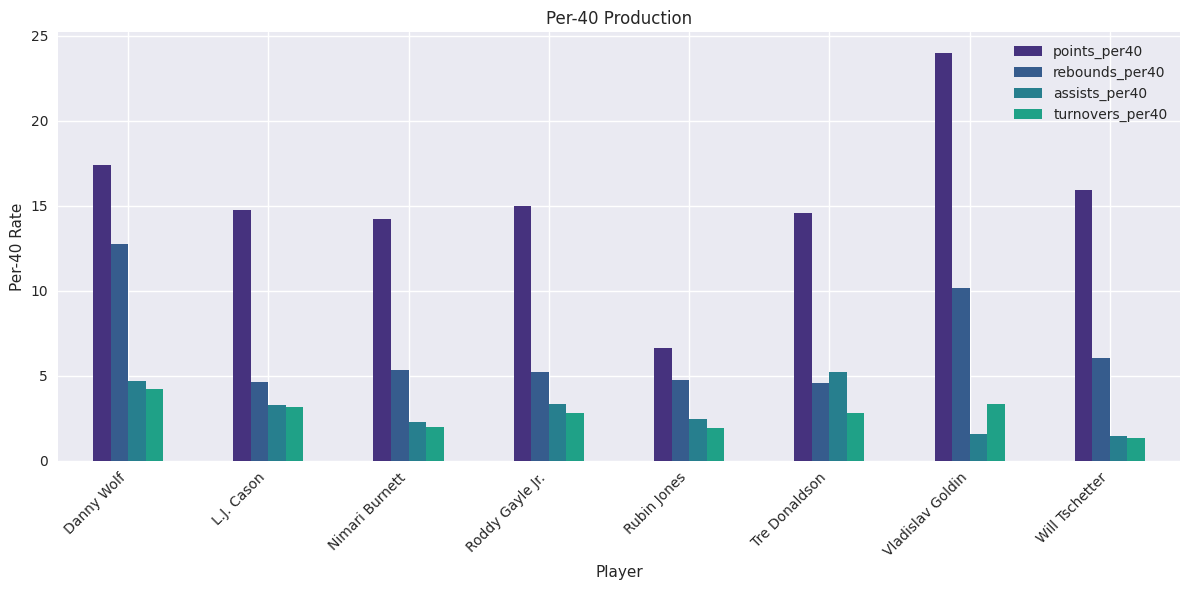

In [10]:
# 📈 Per-40 bar chart
per40_cols = [col for col in PER40_METRICS if col in selected.columns]
per40_data = selected[['player_name'] + per40_cols].set_index('player_name').sort_index()

ax = per40_data.plot(kind='bar', figsize=(12, 6))
ax.set_title('Per-40 Production')
ax.set_ylabel('Per-40 Rate')
ax.set_xlabel('Player')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## 📉 Efficiency dashboard
Efficiency stats reveal how costly a player's usage is. Watch for big gaps in true shooting or turnover rate—they often drive coaching decisions.

Compare shooting and possession efficiency metrics to understand who converts chances.


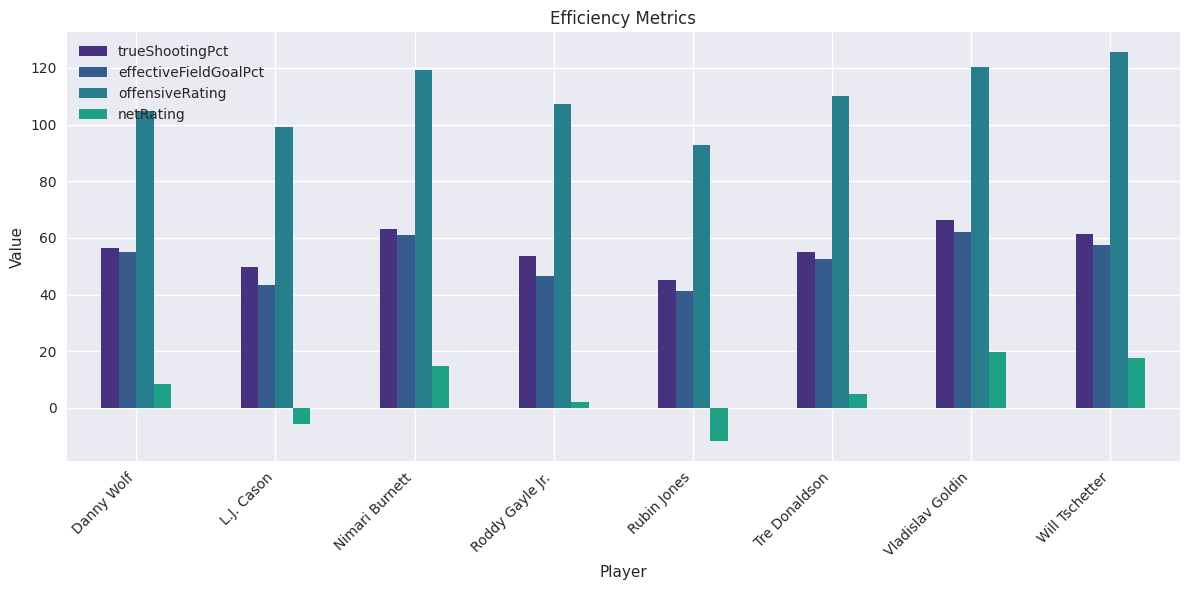

In [11]:
# 📉 Efficiency bar chart
eff_cols = [col for col in EFFICIENCY_METRICS if col in selected.columns]
eff_data = selected[['player_name'] + eff_cols].set_index('player_name').sort_index()

ax = eff_data.plot(kind='bar', figsize=(12, 6))
ax.set_title('Efficiency Metrics')
ax.set_ylabel('Value')
ax.set_xlabel('Player')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



## 🌐 Radar view
Radar plots offer a quick visual fingerprint. Peaks show strengths; dips show potential weaknesses to address in development plans.

Normalize key metrics and plot them on a radar chart for a quick trait comparison.


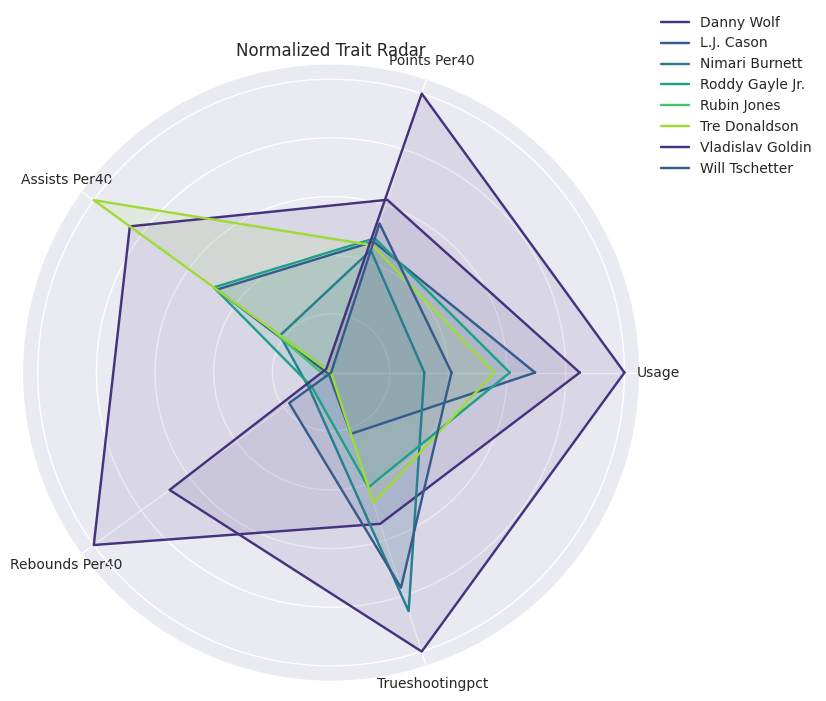

In [12]:
# 🌐 Radar chart
radar_cols = [col for col in RADAR_METRICS if col in selected.columns]
radar_df = selected[['player_name'] + radar_cols].set_index('player_name')

# Normalize 0-1 across selected players for each metric
norm_df = radar_df.copy()
for metric in radar_cols:
    col = radar_df[metric]
    span = col.max() - col.min()
    if span == 0:
        norm_df[metric] = 0.5
    else:
        norm_df[metric] = (col - col.min()) / span

theta = np.linspace(0, 2 * np.pi, len(radar_cols), endpoint=False)
theta = np.concatenate([theta, [theta[0]]])

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
for player, row in norm_df.iterrows():
    values = row.values
    values = np.concatenate([values, [values[0]]])
    ax.plot(theta, values, label=player)
    ax.fill(theta, values, alpha=0.1)

ax.set_xticks(theta[:-1])
ax.set_xticklabels([metric.replace('_', ' ').title() for metric in radar_cols])
ax.set_yticklabels([])
ax.set_title('Normalized Trait Radar')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()



## 🎯 Usage vs efficiency
This scatter plot illustrates the trade-off between volume and effectiveness. Players in the upper-right quadrant are rare—take note.

Check whether higher usage hurts shooting efficiency. Points size indicates usage share.


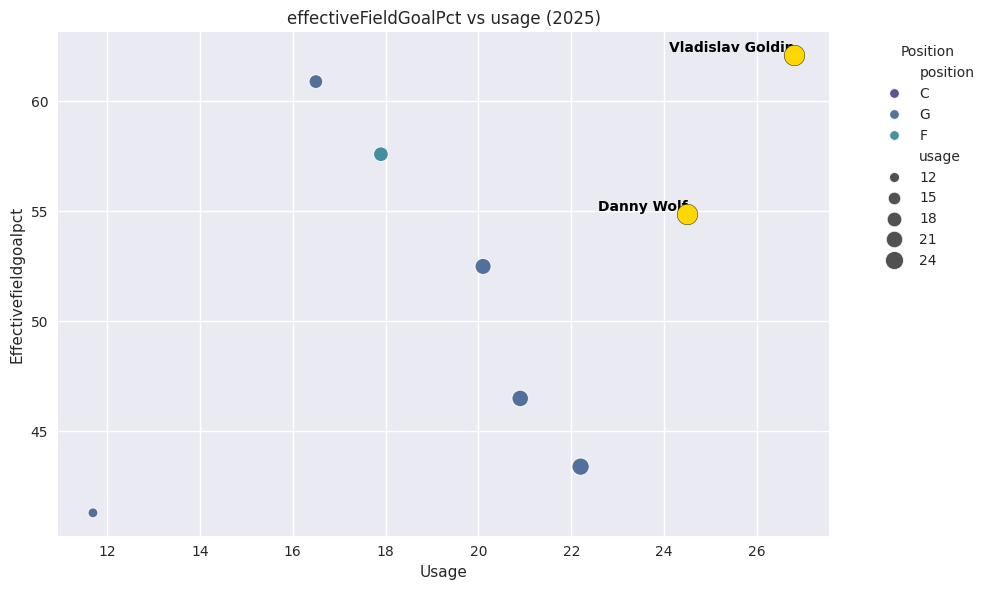

In [16]:
# 🎯 Scatter plot
if SCATTER_X not in selected.columns:
    raise KeyError(f"Scatter X column {SCATTER_X} not found. Choose another metric.")
if SCATTER_Y not in selected.columns:
    raise KeyError(f"Scatter Y column {SCATTER_Y} not found. Choose another metric.")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=selected,
    x=SCATTER_X,
    y=SCATTER_Y,
    hue='position',
    size='usage',
    sizes=(50, 200),
    alpha=0.85
)
plt.title(f"{SCATTER_Y} vs {SCATTER_X} ({TARGET_SEASON})")
plt.xlabel(SCATTER_X.replace('_', ' ').title())
plt.ylabel(SCATTER_Y.replace('_', ' ').title())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Position')

if HIGHLIGHT_PLAYERS:
    highlights = selected.loc[selected['player_name'].isin(HIGHLIGHT_PLAYERS)]
    for _, row in highlights.iterrows():
        plt.scatter(row[SCATTER_X], row[SCATTER_Y], color='gold', edgecolor='black', s=220, zorder=5)
        plt.text(row[SCATTER_X], row[SCATTER_Y], row['player_name'], ha='right', va='bottom', fontsize=10, fontweight='extra bold', color='black')

plt.tight_layout()
plt.show()



## 🧱 Shot mix comparison
The stacked bars show where each player operates. Consider how their shot selection fits with your team's offensive style.

Stacked bars show how often each player attacks the rim, mid-range, and beyond the arc.


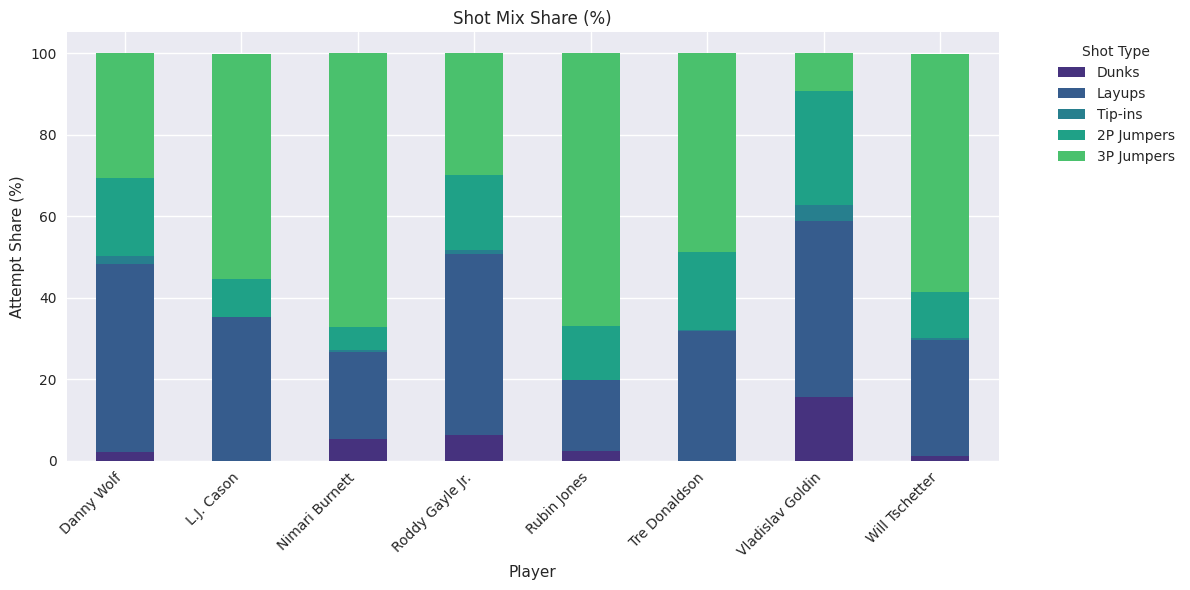

In [17]:
# 🧱 Shot mix bars
share_cols = [f'{shot}_share_pct' for shot in SHOT_TYPES if f'{shot}_share_pct' in selected.columns]
if share_cols:
    plot_data = selected[['player_name'] + share_cols].set_index('player_name')
    plot_data = plot_data.sort_index()

    ax = plot_data.plot(kind='bar', stacked=True, figsize=(12, 6))
    ax.set_title('Shot Mix Share (%)')
    ax.set_ylabel('Attempt Share (%)')
    ax.set_xlabel('Player')
    plt.xticks(rotation=45, ha='right')
    legend_labels = [SHOT_LABELS.get(col.replace('_share_pct', ''), col) for col in share_cols]
    ax.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Shot Type')
    plt.tight_layout()
    plt.show()
else:
    print('Shot mix share columns unavailable for the selected season.')



## 📋 Assisted rate comparison
Assisted percentages reveal who creates their own looks. High assisted rates may indicate a player relies on teammates to set them up.

Spot which players create their own looks versus rely on setup passes.


In [18]:
# 📋 Assisted rate table
assist_cols = [f'{shot}_assisted_pct' for shot in SHOT_TYPES if f'{shot}_assisted_pct' in selected.columns]
if assist_cols:
    assist_table = selected[['player_name'] + assist_cols].set_index('player_name')
    display(assist_table.round(1))
else:
    print('Assisted percentage metrics not available for this season.')



,dunks_assisted_pct,layups_assisted_pct,twoPointJumpers_assisted_pct,threePointJumpers_assisted_pct
player_name,,,,
Danny Wolf,42.90,38.80,3.70,64.90
L.J. Cason,0.00,28.60,0.00,69.20
Nimari Burnett,83.30,55.20,33.30,95.50
Roddy Gayle Jr.,100.00,42.40,36.80,77.80
Rubin Jones,33.30,33.30,0.00,80.00
Tre Donaldson,0.00,12.30,7.40,80.30
Vladislav Goldin,86.00,65.60,63.00,81.80
Will Tschetter,100.00,62.50,71.40,100.00


## ✅ Next steps
Capture your conclusions in a short paragraph. These notes feed directly into matchup scouts or recruiting dossiers.

- Bring in rolling game windows from `player_game_stats` to monitor recent form versus season averages.
- Add percentile ranks by comparing against the full player pool before filtering.
- Export `summary_table` and `selected` to CSV (`to_csv`) for scouting packets or dashboards.
